In [1]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
from util import opt_vehicle, traffic_light, vertex
import numpy as np


delta_x = 10
epslon = 10 ** -6
v_max = 22
delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8

timeset = [20, 5, 25]                       # red, yellow, green
t0 = 40                                     # initial clock
light_location = 50
light = traffic_light(t0, timeset, light_location)
x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
dt = 0.01

# 1. build the graph
init_ver = vertex(0, 15, 0)     # initial state

# start from the init_ver, expand all possible vertices
# define m+1 as the number of x lattice, n as number of v lattice
m = 5
n = 23
dx = (light_location - init_ver.x) / m
loc_grid = np.linspace(dx, light_location + dx, m + 1)
vel_grid = np.linspace(0, v_max, n)
init_light = light.give_clock(0)


# some features for MDP
last_states = []

In [3]:
loc_grid[-2]

50.0

In [3]:
# method using class to represent vertex

depth = 0

def create_descendent(ver, x, v):
    delta_v = v - ver.v
    delta_t = 2 * dx/(v + ver.v)
    a = delta_v / delta_t
    if a <= a_max and a >= a_min:
        # dynamic check
        j = delta_t * w1 / delta_t_min + abs(a/a_max) * w2
        new_ver = vertex(x, v, ver.t + delta_t)
        new_ver.in_edge.append([ver, delta_t, j, a])
        ver.out_edge.append([new_ver, delta_t, j, a])
        
    
        if np.isclose(x, loc_grid[-1]):
            new_ver.h = -100      # reward for passing the intersection
            last_states.append(new_ver)
            return
        else:
            expand(new_ver)

def expand(ver):
    # in python, the address is assigned when you assign one variable
    # to another, so when new vertex is created, as long as it is saved
    # in edge, it's fine
    # some logic:
    # a. if the start light is red (3), at intersection, v>0 is not allowed; before and after intersection, v = 0 is not allowed
    # b. if start light is other, v = 0 is not allowed all spaces
    x = ver.x + dx
    if init_light == 3:
        # red light
        if np.isclose(x, light.location):
            create_descendent(ver, x, 0)
        else:
            for v in vel_grid[1:]:
                # no v = 0
                create_descendent(ver, x, v)
    else:
        # other light, no v=0 at all
        for v in vel_grid[1:]:
            create_descendent(ver, x, v)
            
expand(init_ver)

# now the graph is built, and we need only 1 value iteration for the whole MDP, to calculate the utility function.
# Calculation of utility function starts with states saved in last_states



In [8]:
# method using dictionary to represent vertex


nodes = []
last_states = []

init_state = {
    "x": 0,
    "v": 15,
    "init_light": init_light,
    "t": 0,
    "in_edge": [],
    "out_edge": [],
    "h": 9999}

def create_descendent(ver, x, v, dx):
    delta_v = v - ver["v"]
    delta_t = 2 * dx/(v + ver["v"])
    a = delta_v / delta_t
    if a <= a_max and a >= a_min:
        # dynamic check
        j = delta_t * w1 / delta_t_min + abs(a/a_max) * w2
        new_ver = {
            "x": x,
            "v": v,
            "init_light": init_light,
            "t": ver["t"] + delta_t,
            "in_edge": [],
            "out_edge": [],
            "h": 9999}
        new_ver["in_edge"].append([ver, delta_t, j, a])
        ver["out_edge"].append([new_ver, delta_t, j, a])
        
    
        if np.isclose(x, loc_grid[-1]):
            new_ver["h"] = -100      # reward for passing the intersection, -100
            last_states.append(new_ver)
            nodes.append(new_ver)
            return
        else:
            nodes.append(new_ver)
            expand(new_ver)

def expand(ver):
    # in python, the address is assigned when you assign one variable
    # to another, so when new vertex is created, as long as it is saved
    # in edge, it's fine
    # some logic:
    # a. if the start light is red (3), at intersection, v>0 is not allowed; before and after intersection, v = 0 is not allowed
    # b. if start light is other, v = 0 is not allowed all spaces
    x = ver["x"] + dx
    if init_light == 3:
        # red light
        if np.isclose(x, light.location):
            create_descendent(ver, x, 0)
        else:
            for v in vel_grid[1:]:
                # no v = 0
                create_descendent(ver, x, v)
    else:
        # other light, no v=0 at all
        for v in vel_grid[1:]:
            create_descendent(ver, x, v)

expand(init_state)

# now the graph is built, and we need only 1 value iteration for the whole MDP, to calculate the utility function.
# Calculation of utility function starts with states saved in last_states, then propagates to all vertices at the front
# location layer by layer
graph = pd.DataFrame(nodes)

## 1. generate the optimal deterministic solu

In [2]:
from util import opt_vehicle, traffic_light, vertex
from optimizer import dfs_optimizer
import numpy as np
import pandas as pd

# we need to get the optimial solution for each vertex when traffic light changed, clock is the time at the change.
# This is calculated and saved in a file, which helps the calculation of MDP function.



delta_x = 10
epslon = 10 ** -6
v_max = 22
delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8

timeset = [20, 5, 25]                       # red, yellow, green
t0 = 0                                     # initial clock
light_location = 50
light = traffic_light(t0, timeset, light_location)
x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
dt = 0.01

# 1. build the graph
init_ver = vertex(0, 15, 0)     # initial state

# start from the init_ver, expand all possible vertices
# define m+1 as the number of x lattice, n as number of v lattice
m = 5
n = 23
dx = (light_location - init_ver.x) / m
loc_grid = np.linspace(dx, light_location + dx, m + 1)
vel_grid = np.linspace(0, v_max, n)
init_light = light.give_clock(0)


def next_clock(init_light):
    # try to generate on state's optimal solution
    if init_light == 1:
        # green light, next light is yellow
        t0_opt = light.gre_dur
    elif init_light == 2:
        # yellow light, next light is red
        t0_opt = light.T - light.red_dur
    else:
        # red light, next light is green
        t0_opt = 0
    return t0_opt

def this_clock(init_light):
    # try to generate on state's optimal solution
    if init_light == 1:
        # green light
        t0_opt = 0
    elif init_light == 2:
        # yellow light, next light is red
        t0_opt = light.gre_dur
    else:
        # red light, next light is green
        t0_opt = light.T - light.red_dur
    return t0_opt

fix_sols = []
# opt_light = traffic_light(t0_opt, timeset, light_location)


m = 3
n = 23
dv = 1

for init_light in [1, 2, 3]:

    opt_light = traffic_light(this_clock(init_light), timeset, light_location)
    x0_ = [0, 12, opt_light.give_clock(0)]
    car = opt_vehicle(dx, v_max, a_max, a_min, opt_light, x0_)
    
    for v in vel_grid:
        for x in loc_grid[:-1]:
            
            
            optimizer = dfs_optimizer(opt_light, car)
            plan, cost, vel = optimizer.solver(x, v, dv)
            item = {"x": x, 
                   "v": v,
                   "cost": cost,
                   "plan": plan,
                   "vel": vel,
                   "init_light": init_light}
            fix_sols.append(item)
            


fixed_result = pd.DataFrame(fix_sols)

# save the file for future use
filename = str(timeset[0])+'-'+str(timeset[1])+'-'+str(timeset[2])+'.csv'
fixed_result.to_csv(filename, sep='\t')

1 10.0 0.0
solved!
1 20.0 0.0
solved!
1 30.0 0.0
solved!
1 40.0 0.0
solved!
1 50.0 0.0
solved!
1 10.0 1.0
solved!
1 20.0 1.0
solved!
1 30.0 1.0
solved!
1 40.0 1.0
solved!
1 50.0 1.0
solved!
1 10.0 2.0
solved!
1 20.0 2.0
solved!
1 30.0 2.0
solved!
1 40.0 2.0
solved!
1 50.0 2.0
solved!
1 10.0 3.0
solved!
1 20.0 3.0
solved!
1 30.0 3.0
solved!
1 40.0 3.0
solved!
1 50.0 3.0
solved!
1 10.0 4.0
solved!
1 20.0 4.0
solved!
1 30.0 4.0
solved!
1 40.0 4.0
solved!
1 50.0 4.0
solved!
1 10.0 5.0
solved!
1 20.0 5.0
solved!
1 30.0 5.0
solved!
1 40.0 5.0
solved!
1 50.0 5.0
solved!
1 10.0 6.0
solved!
1 20.0 6.0
solved!
1 30.0 6.0
solved!
1 40.0 6.0
solved!
1 50.0 6.0
solved!
1 10.0 7.0
solved!
1 20.0 7.0
solved!
1 30.0 7.0
solved!
1 40.0 7.0
solved!
1 50.0 7.0
solved!
1 10.0 8.0
solved!
1 20.0 8.0
solved!
1 30.0 8.0
solved!
1 40.0 8.0
solved!
1 50.0 8.0
solved!
1 10.0 9.0
solved!
1 20.0 9.0
solved!
1 30.0 9.0
solved!
1 40.0 9.0
solved!
1 50.0 9.0
solved!
1 10.0 10.0
solved!
1 20.0 10.0
solved!
1 30.0 10.

## 2. generate all possible paths for the stochastic problem

In [17]:
# method using dictionary to represent vertex


nodes = []
last_states = []

init_state = {
    "x": 0,
    "v": 15,
    "init_light": init_light,
    "t": 0,
    "in_edge": [],
    "out_edge": [],
    "h": 99999}

def create_descendent(ver, x, v, dx):
    delta_v = v - ver["v"]
    delta_t = 2 * dx/(v + ver["v"])
    a = delta_v / delta_t
    if a <= a_max and a >= a_min:
        # dynamic check
        j = delta_t * w1 / delta_t_min + abs(a/a_max) * w2
        new_ver = {
            "x": x,
            "v": v,
            "init_light": init_light,
            "t": ver["t"] + delta_t,
            "in_edge": [],
            "out_edge": [],
            "h": 99999}
        new_ver["in_edge"].append([x, v, delta_t, j, a])
        ver["out_edge"].append([x, v, delta_t, j, a])
        
    
        if np.isclose(x, loc_grid[-1]):
            new_ver["h"] = -100      # reward for passing the intersection, -100
            last_states.append(new_ver)
            nodes.append(new_ver)
            return
        else:
            nodes.append(new_ver)
            expand(new_ver)

def expand(ver):
    # in python, the address is assigned when you assign one variable
    # to another, so when new vertex is created, as long as it is saved
    # in edge, it's fine
    # some logic:
    # a. if the start light is red (3), at intersection, v>0 is not allowed; before and after intersection, v = 0 is not allowed
    # b. if start light is other, v = 0 is not allowed all spaces
    x = ver["x"] + dx
    if init_light == 3:
        # red light
        if np.isclose(x, light.location):
            create_descendent(ver, x, 0)
        else:
            for v in vel_grid[1:]:
                # no v = 0
                create_descendent(ver, x, v)
    else:
        # other light, no v=0 at all
        for v in vel_grid[1:]:
            create_descendent(ver, x, v)

expand(init_state)

# now the graph is built, and we need only 1 value iteration for the whole MDP, to calculate the utility function.
# Calculation of utility function starts with states saved in last_states, then propagates to all vertices at the front
# location layer by layer
graph = pd.DataFrame(nodes)

NameError: name 'dx' is not defined

In [23]:
class stochastic_light:
    # this 'stochastic' here means the vehicle knows the light pattern (green, yellow, red)
    # duration of the signal, but the clock of the light is unkown
    def __init__(self, light, init_state, m, n, v_max, car):
        self.light = light
        self.init_state = init_state
        self.init_light = light.give_clock(0)
        self.next_light = (self.init_light + 1)%3
        if self.init_light == 1:
            self.cur_period = self.light.gre_dur
        elif self.init_light == 2:
            self.cur_period = self.light.yel_dur
        else:
            self.cur_period = self.light.red_dur
        self.m = m
        self.n = n
        self.dx = (light.location - init_state["x"]) / m
        self.dv = v_max / (n - 1)
        self.loc_grid = np.linspace(self.dx, light.location + self.dx, m + 1)
        self.vel_grid = np.linspace(0, v_max, n)
        self.nodes = [self.init_state]
        filename = str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'.csv'
        self.fixed_result = pd.read_csv(filename, sep='\t')
        self.car = car
    
    def unchange_prob_uni(self, state, delta_t):
        # uniform distribution
        return 1 - self.change_prob(state, delta_t)
    
    def change_prob_uni(self, ver, delta_t):
        # uniform distribution
        prob = delta_t/(self.cur_period - ver["t"])
        if prob < 0 :
            prob = 1
        return min(prob, 1)
    
    def change_prob_uni_df(self, index, delta_t):
        prob = delta_t/(self.cur_period - self.node_frame["t"][index])
        if prob < 0:
            prob = 1
        return prob
    
    def unchange_prob_uni_df(self, index, delta_t):
        # uniform distribution
        return 1 - self.change_prob_df(index, delta_t)
    
    def create_descendent(self, ver, x, v):
        
        delta_v = v - ver["v"]
        delta_t = 2 * self.dx/(v + ver["v"])
    
    
        a = delta_v / delta_t
        if a <= a_max and a >= a_min:
            # dynamic check
            j = delta_t * w1 / delta_t_min + abs(a/a_max) * w2
            
            prob = self.change_prob_uni(ver, delta_t)
            if np.isclose(prob, 1):
                new_ver = {
                    "x": x,
                    "v": v,
                    "init_light": self.init_light,
                    "t": ver["t"] + delta_t,
                    "out_edge": [],
                    "h": 99999,
                    "must_happen": 1}
            else:
                new_ver = {
                    "x": x,
                    "v": v,
                    "init_light": self.init_light,
                    "t": ver["t"] + delta_t,
                    "out_edge": [],
                    "h": 99999,
                    "must_happen": -1}
            
            # new_ver["in_edge"].append([x, v, delta_t, j, a, prob])
            ver["out_edge"].append([x, v, delta_t, j, a, prob])

#             end expand condition:
#                 1. expand till the intersection location
#                 2. one next state is gonna to change, this must happen
            if np.isclose(x, self.loc_grid[-2]):
                new_ver["h"] = float(self.fixed_result[self.fixed_result["init_light"] == self.init_light][self.fixed_result["x"] == x][self.fixed_result["v"] == v]["cost"].values[0])      # reward for passing the intersection, -100
                
                self.nodes.append(new_ver)
                return
            elif new_ver["must_happen"] > 0:
                # it is going to happen, no descendent
                return
            else:
                self.nodes.append(new_ver)
                self.expand(new_ver)
    
    def expand(self, ver):
        # in python, the address is assigned when you assign one variable
        # to another, so when new vertex is created, as long as it is saved
        # in edge, it's fine
        # some logic:
        # a. if the start light is red (3), at intersection, v>0 is not allowed; before and after intersection, v = 0 is not allowed
        # b. if start light is other, v = 0 is not allowed all spaces
        x = ver["x"] + self.dx
        if init_light == 3:
            # red light, for safety, assume next state you can only stop
            if np.isclose(x, light.location):
                self.create_descendent(ver, x, 0)
            else:
                for v in self.vel_grid[1:]:
                    # no v = 0
                    self.create_descendent(ver, x, v)
        else:
            # other light, need to consider the case that light will change within the travel of last dx to intersection
            for v in self.vel_grid:
                self.create_descendent(ver, x, v)
    
    def backtrack(self):
        # generate the MDP model, which comes from the last column till the first based on Bellman equation
        
        mdp = []
        # 1. first, transfer list to a dataframe
        self.node_frame = pd.DataFrame(self.nodes)
        
        # 2. second, from the second last column till the first, generate the utility func for each node by Bellman's equation
        # h_1(s) = min_a {p(light change, s1| a, s)*h_2(s1) + p(light not change, s2| a, s)*h_2(s2)
        for i in range(self.m ):
            x = self.loc_grid[self.m - i - 1] - 10
            
            for j in self.node_frame[self.node_frame["x"] == x].index:
                best_index = 0
                edges = self.node_frame["out_edge"][j]
                if len(edges) > 0:
    #                 edge: [x, v, delta_t, j, a, change_prob]
                    # print(self.node_frame[self.node_frame["init_light"] == self.init_light][self.node_frame["x"] == edges[0][0]]["h"].values)
                    min_h = edges[0][-1] * float(self.fixed_result[self.fixed_result["init_light"] == self.next_light][self.fixed_result["x"] == edges[0][0]][self.fixed_result["v"] == edges[0][1]]["cost"].values[0]) + \
                            (1 - edges[0][-1]) * self.node_frame[self.node_frame["x"] == edges[0][0]][self.node_frame["v"] == edges[0][1]]["h"].values[0] + \
                            edges[0][3]
                    for k in range(1, len(edges)):
                        h = edges[k][-1] * float(self.fixed_result[self.fixed_result["init_light"] == self.next_light][self.fixed_result["x"] == edges[k][0]][self.fixed_result["v"] == edges[k][1]]["cost"].values[0]) + \
                            (1 - edges[k][-1]) * self.node_frame[self.node_frame["x"] == edges[k][0]][self.node_frame["v"] == edges[k][1]]["h"].values[0] + \
                            edges[k][3]
                        if h < min_h:
                            best_index = k
                            min_h = h

                    self.node_frame["h"][j] = min_h
                    # save the result
                    state = {
                        "x" : x,
                        "v" : self.node_frame["v"][j],
                        "t" : self.node_frame["t"][j],
                        "best_action" : edges[best_index][-2],
                        "h" : min_h,
                        "prob_change": edges[best_index][-1]
                    }
                    mdp.append(state)
        
        # then we save the result
        self.mdp_result = pd.DataFrame(mdp)
        filename = str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'_sto.csv'
        self.mdp_result.to_csv(filename, sep='\t')
#         for i in self.node_frame[self.node_frame["x"] == self.dx].index:
#             delta_v = self.node_frame["v"][i] - self.init_state["v"]
#             delta_t = 2 * self.dx / (self.node_frame["v"][i] + self.init_state["v"])
#             a = delta_v / delta_t
#             if a <= self.car.a_max and a >= self.car.a_min:
#                 j = delta_t * self.car.w1 / self.car.delta_t_min + abs(a/self.car.a_max) * self.car.w2
    def load_prior(self):
        filename = str(self.light.red_dur)+'-'+str(self.light.yel_dur)+'-'+str(self.light.gre_dur)+'_sto.csv'
        try:
            self.mdp = pd.read_csv(filename, sep = '\t')
            print("file opened!")
        except:
            print(filename + " doesn't exists in the local path!")
    
    def controller(self, x):
        pass
#         if self.go_after_redlight:
#             if x[0] < self.light.location + self.car.delta_x:
#                 return self.optimal_control[-1]
#         if x[0] < self.light.location:
#             if x[2] != 3:
#                 # if x[3] == 3 and self.light.location - x[0] < 0.5 and x[1] == 0:
#                 if x[3] == 3 and self.stop_at_redlight:
#                     self.go_after_redlight = True
#                     return self.optimal_control[-1]
#                 index = math.floor((x[0] - self.car.x0[0])/self.car.delta_x)
#                 # print(x[0], self.car.x0[0], self.car.delta_x, index)
#                 return self.optimal_control[index] + self.feedback_controller(x, index)
#             elif x[3] == 3 and self.light.location - x[0] < 0.5 and abs(x[1]) < 0.5:
#                 self.stop_at_redlight = True
#                 return 'stop'
#             else:
#                 index = math.floor((x[0] - self.car.x0[0])/self.car.delta_x)
#                 # print(x[0], self.car.x0[0], self.car.delta_x, index)
#                 return self.optimal_control[index] + self.feedback_controller(x, index)

#         else:
#             return 0
    
    def dynamics(self, s, u):
        #     state of the system
        #     s_k = (y, v, l, l_p)
        #     s_{k+1} = f(s_k, u_k)

        if u == 'stop':
            vel = 0
            location = s[0]
        else:

            location = s[0] + u * self.car.delta_t ** 2 / 2 + s[1] * self.car.delta_t
            vel = s[1] + u * self.car.delta_t
        lp = s[2]
        l = lp
        return [location, vel, l, lp]
        
    

### generate MDP

In [19]:
import time

start_point = time.time()
timeset = [20, 5, 25]                       # red, yellow, green
t0 = 0                                     # initial clock
light_location = 50
init_light = light.give_clock(0)
delta_x = 10
epslon = 10 ** -6
v_max = 22
delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8
m = 5
n = 23

light = traffic_light(t0, timeset, light_location)

init_state = {
    "x": 0,
    "v": 15,
    "init_light": init_light,
    "t": 0,
    "must_happen": -1,
    "out_edge": [],
    "h": 99999}


x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
car = opt_vehicle(delta_x, v_max, a_max, a_min, light, x0)


sto_opt = stochastic_light(light, init_state, m, n, v_max, car)


sto_opt.expand(init_state)
generate_end = time.time()
print("generate skelton time = ", generate_end - start_point)

sto_opt.backtrack()
cal_mdp = time.time()
print("mdp optimization time = ", cal_mdp - generate_end)


/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


generate skelton time =  152.0380928516388


/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mdp optimization time =  928.0378949642181


### utilize the generated MDP

In [24]:
import time

start_point = time.time()
timeset = [20, 5, 25]                       # red, yellow, green
t0 = 0                                     # initial clock
light_location = 50
init_light = light.give_clock(0)
delta_x = 10
epslon = 10 ** -6
v_max = 22
delta_t_min = delta_x / v_max
a_min, a_max = -5, 8
w1, w2 = 1/8, 1/8
m = 5
n = 23

light = traffic_light(t0, timeset, light_location)

init_state = {
    "x": 0,
    "v": 15,
    "init_light": init_light,
    "t": 0,
    "must_happen": -1,
    "out_edge": [],
    "h": 99999}


x0 = [0, 15, light.give_clock(0), light.give_clock(0)]
car = opt_vehicle(delta_x, v_max, a_max, a_min, light, x0)


sto_opt = stochastic_light(light, init_state, m, n, v_max, car)

sto_opt.load_prior()



file opened!


In [25]:
sto_opt.mdp

,Unnamed: 0,best_action,h,prob_change,t,v,x
0,0,7.15,0.983388,1.000000,24.650515,1.0,40.0
1,1,7.00,0.950824,0.138033,14.650515,2.0,40.0
2,2,8.00,0.889976,0.091355,11.317182,3.0,40.0
3,3,7.65,0.864287,0.076646,9.650515,4.0,40.0
4,4,7.20,0.839282,0.067960,8.650515,5.0,40.0


In [91]:
def newline(p1, p2, color):
    # draw a line from p1=[x,y] to p2
    ax = plt.gca()
    ymin, ymax = p1[1], p2[1]
    xmin, xmax = p1[0], p2[0]

    l = mlines.Line2D([xmin, xmax], [ymin, ymax], color=color)
    ax.add_line(l)
    return l

/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/tianqi/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


[10.033539999999995, 19.012000000000057, 1, 1] 0.6
[20.039539999999988, 21.012000000000015, 1, 1] 1.1
[30.125299999999982, 21.012000000000015, 1, 1] 1.58
[40.000940000000114, 21.012000000000015, 1, 1] 2.05
[50.086700000000278, 21.012000000000015, 1, 1] 2.53


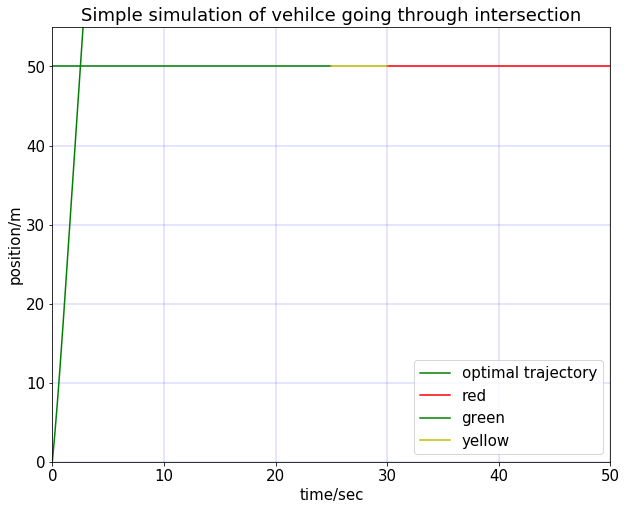

In [94]:
# let's run the result of the mdp
# plot the result trajectory
dt = 0.01
time_real = np.linspace(dt, light.T, 100*light.T)

final_time = light.T
# create the trajcetory
traj = []
vel = []
x = x0
action_mdp = [sto_opt.mdp[sto_opt.mdp["x"] == x0[0]][sto_opt.mdp["v"] == x0[1]]["best_action"].values[0]]

for t in time_real:
    #     traj.append(x)
    if x[0] // sto_opt.dx + 1 > len(action_mdp):
        if x[0] < sto_opt.light.location + sto_opt.dx:
            print(x, t)
            dt = 1000
            index = -1
            # print(t, x[0], x[1], sto_opt.mdp[sto_opt.mdp["x"] == x[0]][sto_opt.mdp["v"] == x[1]]["t"].values)
            for i in range(len(sto_opt.mdp[sto_opt.mdp["x"] == round(x[0])][sto_opt.mdp["v"] == round(x[1])]["t"].values)):
                t_ = sto_opt.mdp[sto_opt.mdp["x"] == round(x[0])][sto_opt.mdp["v"] == round(x[1])]["t"].values[i]
                if abs(t - t_) < dt:
                    dt = abs(t - t_)
                    index = i
                    new_act = sto_opt.mdp[sto_opt.mdp["x"] == round(x[0])][sto_opt.mdp["v"] == round(x[1])]["best_action"].values[index]
            action_mdp.append(new_act)
        else:
            new_act = 'stop'
    
    u = action_mdp[-1]
    
    x = sto_opt.dynamics(x, u)
    
    x[2] = light.give_clock(t)
    traj.append(x[0])
    vel.append(x[1])
    # print(t, x, u)

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10, 8))
# plot the trajectory
# plt.plot(time_real, S[:, 0])
plt.plot(time_real, traj, 'g')
# plt.plot(time_real, vel, 'b')  

red, green, yellow = light.trafficline(final_time)
red_num, green_num, yel_num = len(red), len(green), len(yellow)
for j in range(int(red_num/2)):

    newline(red[2*j], red[2*j + 1], 'r')
for j in range(int(green_num/2)):
    newline(green[2*j], green[2*j + 1], 'g')
for j in range(int(yel_num/2)):
    newline(yellow[2*j], yellow[2*j + 1], 'y')

plt.xlabel('time/sec')
plt.ylabel('position/m')
plt.xlim([0, light.T])
plt.ylim([0, light_location * 1.1])
plt.legend(['optimal trajectory', 'red', 'green', 'yellow'])

plt.title('Simple simulation of vehilce going through intersection')
plt.grid(color='b', linestyle='-', linewidth=.2)
# plt.savefig('through_intersec.png')
plt.show()